### Introduction

This is a recomputation of results from The elasticity of interest rate volatility published by Robert Bliss and David Smith. The authors set out two to accomplish two objectives in their paper
 - Prove that there was a structural shift in interest rates in October 1979 after the Federal reserver experiment.
 - Confirm that the elasiticity of interest rates is 1.5 as was widely accepted by previous reseachers

The relation between the volatility of changes in interest rates and their level is termed the elasticity of interest rate volatility. 
The authors acknowlesdge the inherrent problem of testing a structural shift that tests for evidence of structural
shifts are necessarily joint tests of the shift/no-shift hypotheses and a particular model of the process being studied
 


### Methodology

The authors approach their problem using a single factor diffusion process expressed as:
$$dr = \kappa(\mu-r)dt + \sigma^{\lambda}dz$$
For estimiation purposes the model is discretized using euler's method as:
$$r_{t}-r{t-1}=\alpha + \beta r_{t-1} +\epsilon_{t}$$
$$\epsilon^{2}=\sigma^{2}r^{2\lambda}_{t-1} + \eta_{t}$$
The same approach is used here but without going into testing the special cases of the model where $\alpha$, $\sigma$, $\lambda$ are restricted to the special values in Merton, Vasicek and other models flavours.

### Data

The examination is done using the data from the same sample period as the authors: 1-month Treasury Bill series taken from the 12-month Fama Treasury Bill Files included in the Center for Research in Security Prices (CRSP) monthly Government Bonds Files. We initially restrict our analysis to the June 1964 through December 1989 period to ensure comparability with CKLS.

In [32]:
%config IPCompleter.greedy=True

import pandas as pd
rates = pd.read_csv('./Monthly TBills.csv', index_col='Date', usecols=['Date','Adj Close'])
rates['Adj Close'] /=100 
# ensure is a dtaframe not series
print(type(rates))
# ensure type is float
print(rates.dtypes)

#check for null
assert len(rates.loc[pd.isnull(rates['Adj Close']),:])==0

#
print(f"Data contains: {len(rates)} records")

## prepare columns for GMM
rates['rt-1'] = rates.shift(1).fillna(0)
rates['y'] = rates['Adj Close'] -rates['rt-1']
# remove first row
rates = rates.iloc[1:, :]
rates['intercept'] = 1

rates.head()

<class 'pandas.core.frame.DataFrame'>
Adj Close    float64
dtype: object
Data contains: 307 records


,Adj Close,rt-1,y,intercept
Date,,,,
1964-07-01,0.0347,0.0347,0.0000,1
1964-08-01,0.0350,0.0347,0.0003,1
1964-09-01,0.0355,0.0350,0.0005,1
1964-10-01,0.0355,0.0355,0.0000,1
1964-11-01,0.0384,0.0355,0.0029,1


### Model Estimation and testing

The model is estimated using the GMM method described as:
$$g_{t}(\theta) = [\epsilon_{t},\epsilon_{t}r_{t-1},\eta_{t},\eta_{t} r_{t-1}]$$
$$E[g_{t}(\theta)]=0$$

This model is exactly identified because we have 4 moment conditions and 4 parameters in our model.

In [33]:
from statsmodels.sandbox.regression.gmm import GMM
endog = rates.loc[:,'y'].values
exog = rates.loc[:,['intercept', 'rt-1']].values

In [34]:
class GMMRates(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        # kwds.setdefault('k_moms', 4)
        # kwds.setdefault('k_params', 4)
        super(GMMRates, self).__init__(*args, **kwds)


    def momcond(self, params):
        alpha, beta, sigma, lambda_ = params
        
        endog = self.endog
        n = len(endog)
        r_t_1 = self.exog[:, 1]
        y_hat = alpha  + beta* r_t_1
        error = endog - y_hat
        corr_error = error * r_t_1
        eta = error**2 - (sigma**2)*r_t_1**(2*lambda_)
        corr_eta = eta*r_t_1
        g = np.column_stack((error.mean(), corr_error.mean(), eta.mean(), corr_eta.mean()))
        return g

import numpy as np
model = GMMRates(endog=endog, exog=exog, instrument=None, k_moms = 4, k_params=4)
model.set_param_names(["alpha", "beta", "sigma", "lambda_"])

beta0 = np.array([0.50,-0.5, np.sqrt(0.167), 1.2 ])
res = model.fit(beta0, maxiter=2, optim_method='nm', wargs=dict(centered=False))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 244
         Function evaluations: 423
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 92


### Results

Parameters estimated from our recomputation are highlighted below:

In [23]:
res.summary()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 244
         Function evaluations: 423
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 92


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GMMRates Results                               
==============================================================================
Dep. Variable:                      y   Hansen J:                    1.096e-07
Model:                       GMMRates   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Sat, 30 May 2020                                         
Time:                        11:59:01                                         
No. Observations:                 306                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0024   2.57e-09   9.46e+05      0.000       0.002       0.002
beta          -0.0333   1.45e-07   -2.3e+05      0.000      -0.033      -0.033
sigma          0.4739      0.000   2635.549      0.000       0.474       0.474
lambda_        1.7165      0.000   1.04e+04      0.000       1.716       1.717
==============================================================================
"""

Contrary to the author's finding of the base model we estimate that $\lambda=1.7$. All other parameters differ in value but have the same sign.

### Simulation

Below is a comparison of simulated paths of interest rates using our estimated parameters versus those of the Robert and David. 

c:\users\rmacharia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


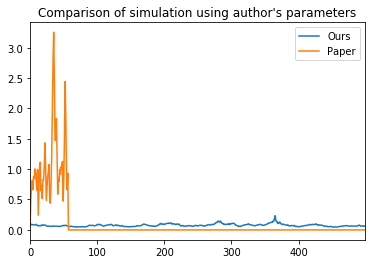

In [38]:
alpha, beta, sigma, lambda_ = res.params

last_val = rates.loc[:,'Adj Close'][-1]
from dataclasses import dataclass

@dataclass
class SimulationsGen:

    alpha: float
    beta:float
    sigma:float
    lambda_:float
    
    init_val:float
    n:int
    sim_count:int
    results: list
    
        
    def _get_delta_c_not_working(self, previous_val ):
        eta = np.random.standard_normal((1,))[0]
        error = (sigma*(previous_val**self.lambda_) )**2  + eta
        error = error if error>=0 and not np.isinf(error) else 0.01
        
        #print(error)
        delta_C = self.alpha + self.beta* previous_val 
        
        return delta_C   
    
    def _get_delta_c(self, previous_val ):
        delta_C = self.alpha + self.beta* previous_val  + \
                self.sigma*(previous_val**self.lambda_)*np.random.standard_normal((1,))[0]
        delta_C = delta_C if not np.isnan(delta_C)else 0.0
        #print(delta_C)
        return delta_C   


    def _generate_one_simulation(self):
        simulation = np.empty(self.n)
        simulation[0] = self.init_val
        for i in range(1,self.n):
            simulation[i] = simulation[i-1] + self._get_delta_c(simulation[i-1])
        return simulation
    
    def generate_many_simulations(self):
        self.results = [self._generate_one_simulation() for i in range(self.sim_count)]

#our simulation
simsOurs = SimulationsGen(alpha=alpha, beta=beta, sigma=sigma, lambda_=lambda_, init_val=last_val, n=500, sim_count=1, results=[])

#simulation from the paper
simsPaper = SimulationsGen(alpha=0.480, beta=-0.592, sigma=np.sqrt(0.167), lambda_=1.5, init_val=last_val, n=500, sim_count=1, results=[])

simsOurs.generate_many_simulations()
simsPaper.generate_many_simulations()

import matplotlib.pyplot as plt
pd.DataFrame({"Ours":simsOurs.results[0], "Paper":simsPaper.results[0]}).plot(title="Comparison of simulation using author's parameters")

The plot above suggests that the author's parameters tend to lead to larger values of the intereats rates.

### Conslusions and further tests

Robert and David had tested various variations of this model that restrict the parameters to particular valus however this examiniation only stops at the base model.

In addition, Robert and David test for structural shifts in the term structurre using a dummy variable to represent pre and post experiment periods. The extended model is expresed as:
$$r_{t}-r{t-1}=(\alpha+\delta_{1}D_{t}) + (\beta+\delta_{2}D_{t}) r_{t-1} +\epsilon_{t}$$
$$\epsilon^{2}=(\sigma^{2}+\delta_{3}D_{t})r^{(2\lambda+\delta_{4}D_{t})}_{t-1} + \eta_{t}$$

This extended model is also estimated using GMM with the moment condition:
$$g_{t}(\theta) = [\epsilon_{t},\epsilon_{t}D_{t},\epsilon_{t}r_{t-1},\epsilon_{t}D_{t}r_{t-1},\eta_{t},\eta_{t}D_{t},\eta_{t} r_{t-1},\eta_{t}D_{t} r_{t-1}]$$
$$E[g_{t}(\theta)]=0$$


Their results show that the dummy variable $D_{t}$ is significant and therefore confirms that there was a structurla break from October 1979 to September 1982.